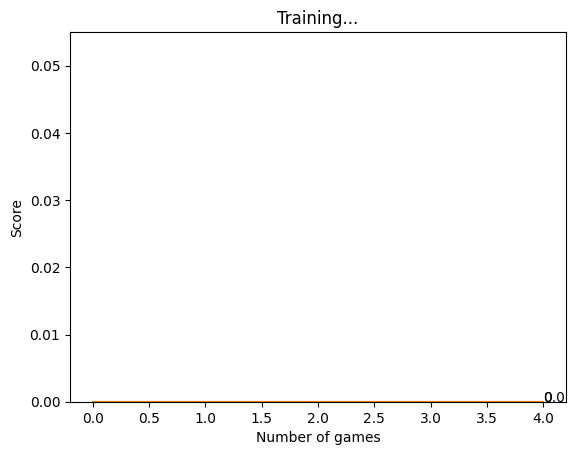

NameError: name 'quit' is not defined

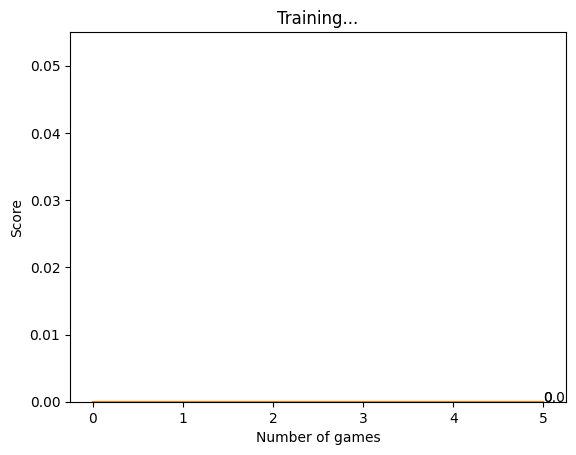

In [1]:
import torch
import random
import numpy as np
from collections import deque
from model import Linear_QNet, QTrainer
from snake_game import SnakeGameAI, Direction, Point
from helper import plot

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

BLOCK_SIZE = 20

class Agent:
    def __init__(self) -> None:
        self.n_games = 0
        self.epsilon = 0 #randomness
        self.gamma = 0.9 #discount rate
        self.memory = deque(maxlen=MAX_MEMORY) #popleft()

        #Load old model
        # model = Linear_QNet(11,256,3)
        # model.load_state_dict(torch.load('model/model.pth'))
        # model.eval()
        # self.model = model

        #Initialize new model
        self.model = Linear_QNet(11, 256, 3)

        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - BLOCK_SIZE, head.y)
        point_r = Point(head.x + BLOCK_SIZE, head.y)
        point_u = Point(head.x, head.y - BLOCK_SIZE)
        point_d = Point(head.x, head.y + BLOCK_SIZE)

        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            #danger straight
            (dir_r and game.is_collision(point_r)) or
            (dir_l and game.is_collision(point_l)) or
            (dir_u and game.is_collision(point_u)) or
            (dir_d and game.is_collision(point_d)),
             
            #danger right
            (dir_u and game.is_collision(point_r)) or
            (dir_d and game.is_collision(point_l)) or
            (dir_l and game.is_collision(point_u)) or
            (dir_r and game.is_collision(point_d)),

            #danger left
            (dir_d and game.is_collision(point_r)) or
            (dir_u and game.is_collision(point_l)) or
            (dir_r and game.is_collision(point_u)) or
            (dir_l and game.is_collision(point_d)),

            #move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,

            #food location
            game.food.x < game.head.x, #food left
            game.food.x > game.head.x, #food right
            game.food.y < game.head.y, #food up
            game.food.y > game.head.y #food down
        ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) #list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)


    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        #random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games #change for loaded model
        final_move = [0,0,0]
        if random.randint(0,200) < self.epsilon:
            move = random.randint(0,2)
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()

        final_move[move] = 1
        return final_move

def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        #get old state
        state_old = agent.get_state(game)

        #get move
        final_move = agent.get_action(state_old)

        #perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        #train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        #remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            #train long memory, plot results
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game ', agent.n_games, 'Score ', score, 'Record ', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)


if __name__ == '__main__':
    train()



In [12]:
from enum import Enum

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4



3